In [37]:
#import modules
import numpy
import scipy
import Bio
import math
import matplotlib
from matplotlib import pyplot
from sklearn import svm
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
random_state = numpy.random.RandomState(0)
from sklearn.decomposition import PCA

#import data in tensor form
final_tensor = numpy.load("/Users/polina_turova/Documents/asp/Bigmingham/work folder/numpy arrays/final_tensor_57_samples.npy",allow_pickle=True)
labels = numpy.load("/Users/polina_turova/Documents/asp/Bigmingham/work folder/numpy arrays/labels_57_samples.npy",allow_pickle=True)
al_time = numpy.arange(3.02,22.0,0.05)

In [11]:
#unfold data tensor
final_tensor_unfolded =[]
for i in range (len(final_tensor)):
    final_tensor_unfolded.append(final_tensor[i].flatten())
final_tensor_unfolded = numpy.array(final_tensor_unfolded)

#decide number of PCA components (explained variance > 95%)
pca = PCA()
pca.fit(final_tensor_unfolded)

for i in range (1,len(final_tensor)):
    y = numpy.sum(pca.explained_variance_ratio_[:i])
    print (i, y)
    if y > 0.95:
        components_95 = i
        break

1 0.29731944349763506
2 0.5096510027980719
3 0.6710053151155022
4 0.774776393190684
5 0.8253709054879622
6 0.8520687910784375
7 0.8754021065432633
8 0.8940216937624259
9 0.9107765230652105
10 0.9247565795789193
11 0.9369180190360498
12 0.946299660006451
13 0.9548404059025928


In [13]:
#perform PCA
pca = PCA(n_components = components_95)
basis = pca.fit_transform(final_tensor_unfolded)
components = pca.components_

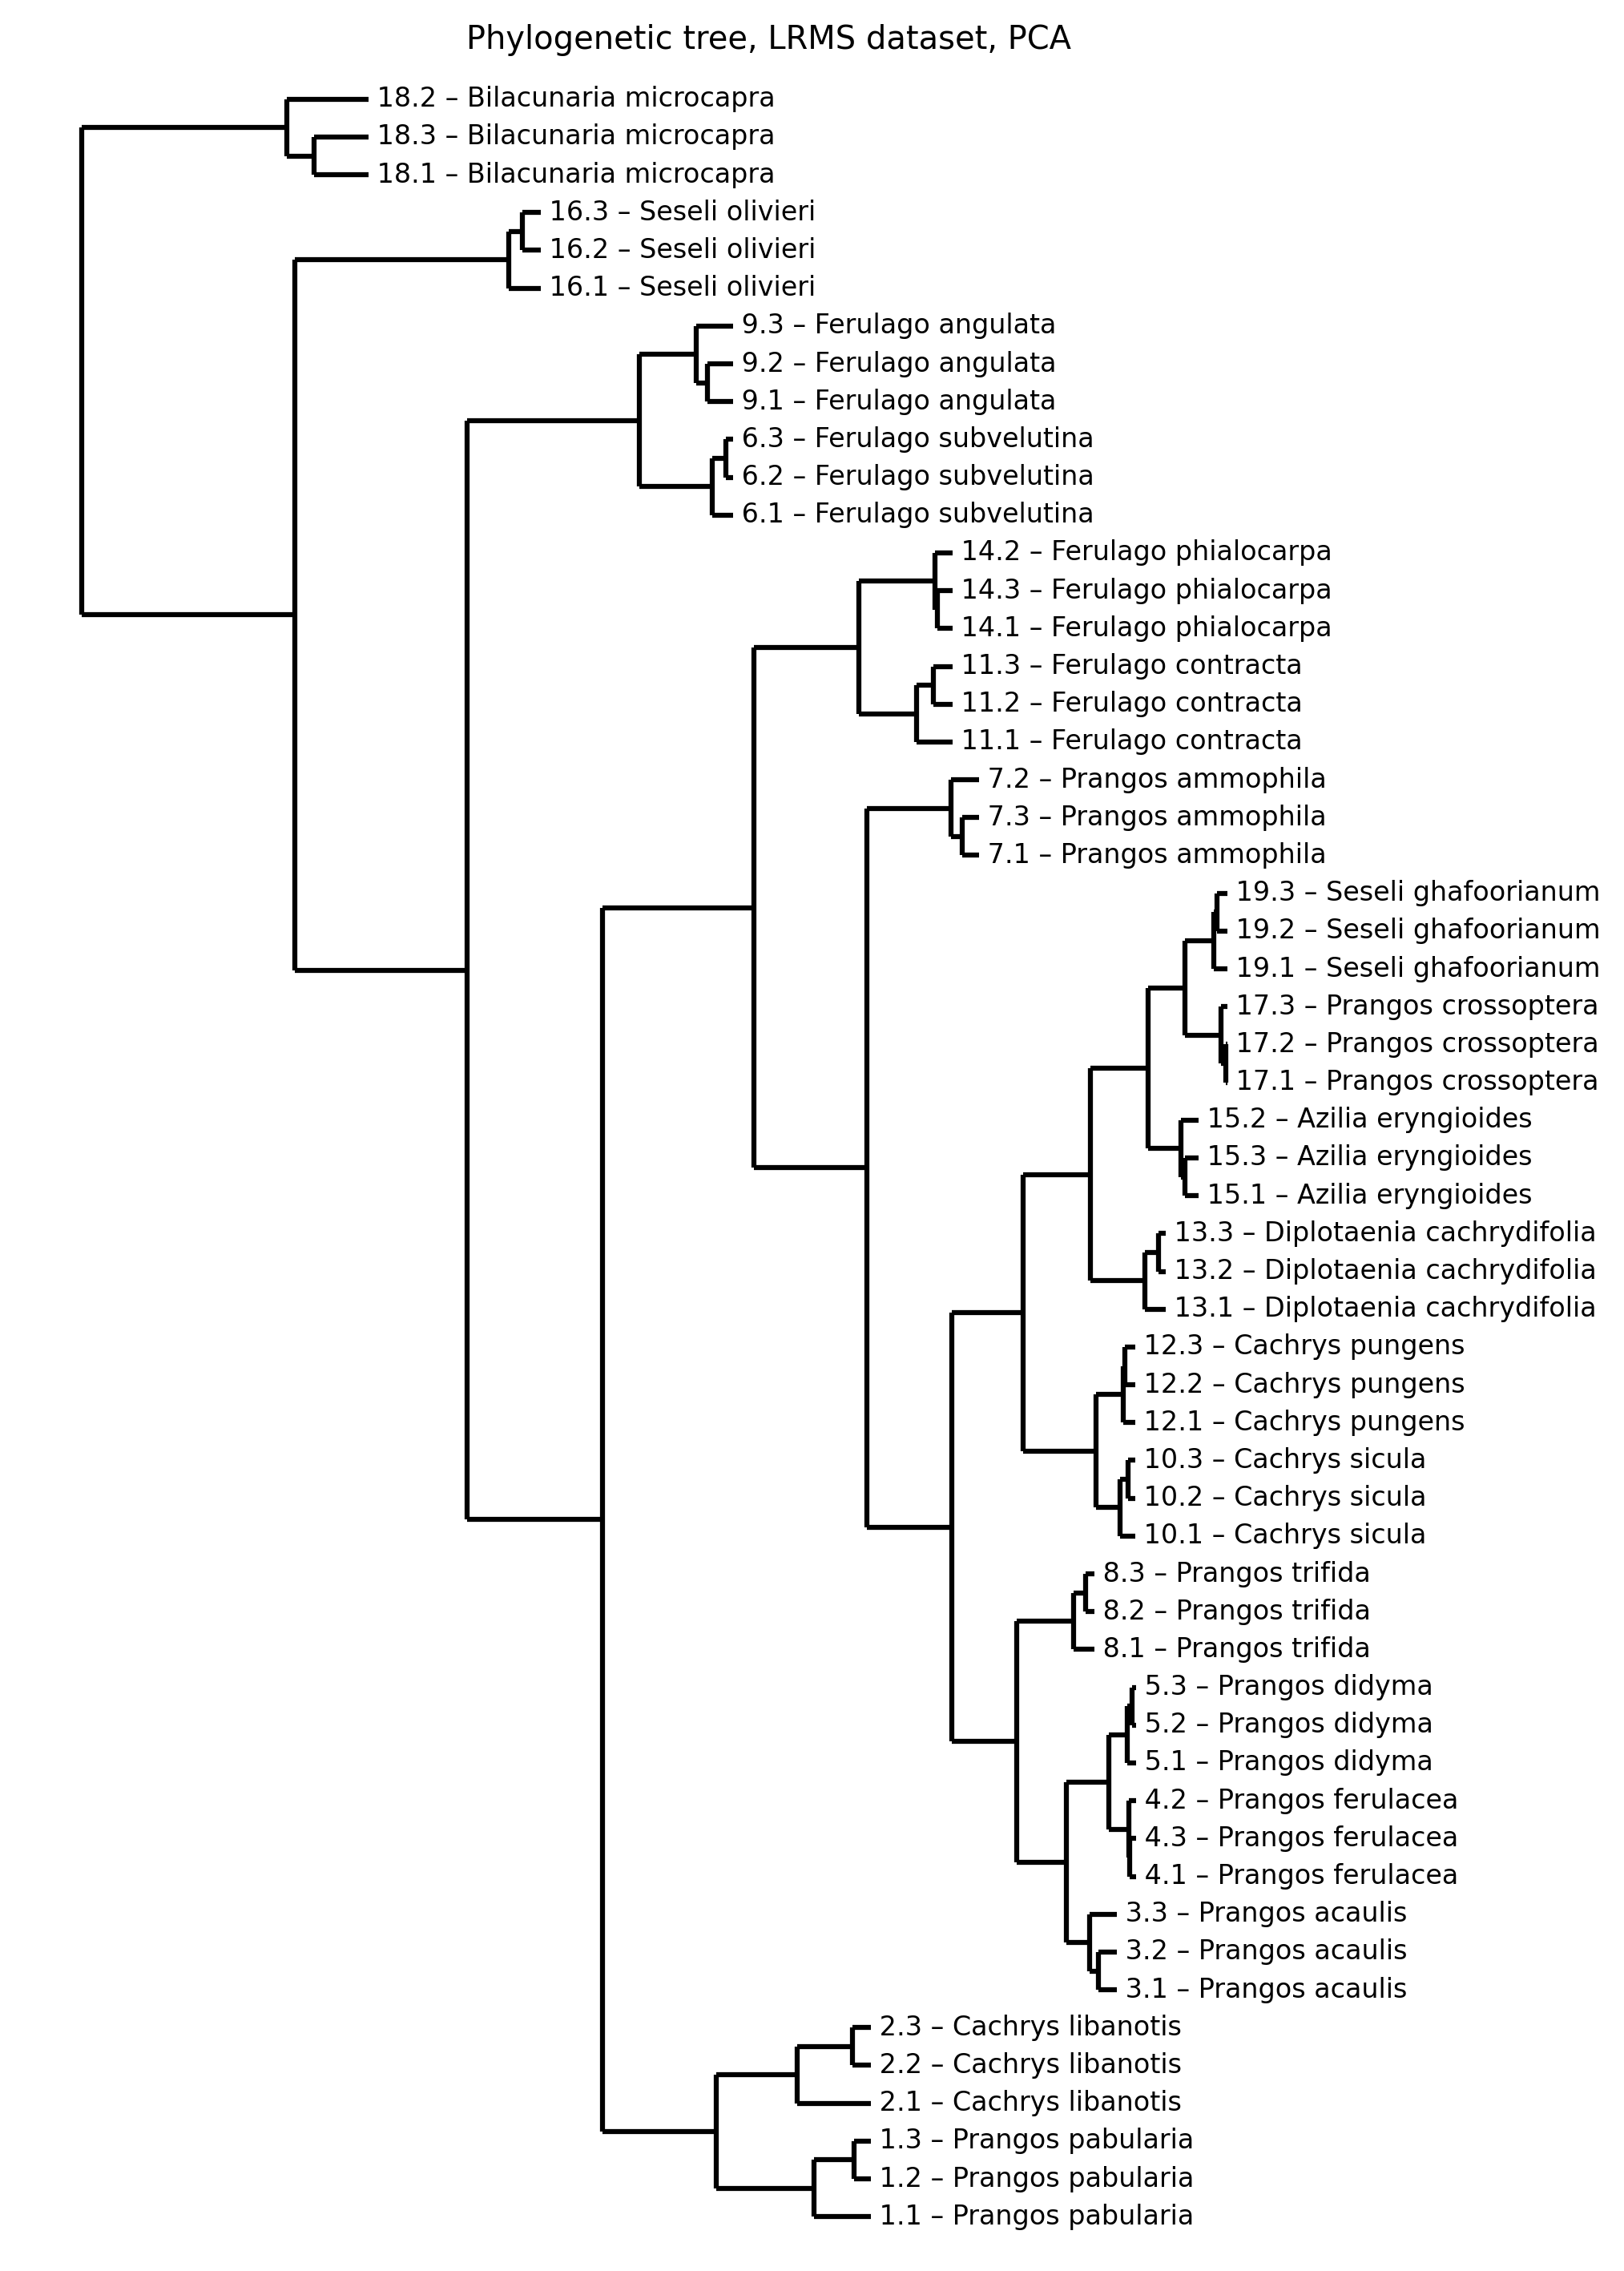

In [18]:
#Visualize phylogenetic tree for PCA decomposition
labels_list = ['1.1 – Prangos pabularia','1.2 – Prangos pabularia','1.3 – Prangos pabularia',
        '2.1 – Cachrys libanotis','2.2 – Cachrys libanotis',
        '2.3 – Cachrys libanotis',
        '3.1 – Prangos acaulis','3.2 – Prangos acaulis','3.3 – Prangos acaulis',
        '4.1 – Prangos ferulacea','4.2 – Prangos ferulacea','4.3 – Prangos ferulacea',
        '5.1 – Prangos didyma','5.2 – Prangos didyma','5.3 – Prangos didyma',
        '6.1 – Ferulago subvelutina',
        '6.2 – Ferulago subvelutina','6.3 – Ferulago subvelutina ',
        '7.1 – Prangos ammophila','7.2 – Prangos ammophila','7.3 – Prangos ammophila',
        '8.1 – Prangos trifida','8.2 – Prangos trifida','8.3 – Prangos trifida',
        '9.1 – Ferulago angulata','9.2 – Ferulago angulata',
        '9.3 – Ferulago angulata',
        '10.1 – Cachrys sicula','10.2 – Cachrys sicula', '10.3 – Cachrys sicula',
        '11.1 – Ferulago contracta','11.2 – Ferulago contracta','11.3 – Ferulago contracta',
        '12.1 – Cachrys pungens',
        '12.2 – Cachrys pungens', '12.3 – Cachrys pungens',
        '13.1 – Diplotaenia cachrydifolia','13.2 – Diplotaenia cachrydifolia','13.3 – Diplotaenia cachrydifolia',
        '14.1 – Ferulago phialocarpa','14.2 – Ferulago phialocarpa','14.3 – Ferulago phialocarpa',
        '15.1 – Azilia eryngioides','15.2 – Azilia eryngioides','15.3 – Azilia eryngioides',
        '16.1 – Seseli olivieri', '16.2 – Seseli olivieri', '16.3 – Seseli olivieri',
        '17.1 – Prangos crossoptera', '17.2 – Prangos crossoptera',
        '17.3 – Prangos crossoptera',
        '18.1 – Bilacunaria microcapra',
        '18.2 – Bilacunaria microcapra','18.3 – Bilacunaria microcapra',
        '19.1 – Seseli ghafoorianum','19.2 – Seseli ghafoorianum','19.3 – Seseli ghafoorianum']

column_list = numpy.arange(1,len(components)+1)

from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio import AlignIO

import pandas as pd
my_dataframe = pd.DataFrame(data=basis,index=labels_list,columns=column_list)

from scipy.spatial import distance_matrix
dist = distance_matrix(my_dataframe.values, my_dataframe.values)
dist_list = dist.tolist()

for i in range (len(dist_list)-1):
    del dist_list[i][i+1:len(labels)]
    
dist_bio = Bio.Phylo.TreeConstruction.DistanceMatrix(labels_list, matrix=dist_list)

constructor = DistanceTreeConstructor(method = 'upgma')
tree = constructor.upgma(dist_bio)

for i in range (1,len(labels_list)):
    name_clade = 'Inner' + str(i)
    tree.common_ancestor({"name": name_clade}).name=''
    
from matplotlib import pyplot as plt
matplotlib.rc('font', size=8)
fig = plt.figure(figsize=(8, 12), dpi=300)
axes = fig.add_subplot(1, 1, 1)
plt.title("Phylogenetic tree, LRMS dataset, PCA")
plt.box(on=None)
plt.axis('off')
Phylo.draw(tree, axes=axes)

In [22]:
#create list of signals with highest weights responsible for 50 compounds
features_list = []
features = []
features_ratio = []
for k in range (len(components)):
    features.append(numpy.argsort(abs(components[k])))
    features_ratio.append(numpy.sort(abs(components[k])))
z = 1
i = 1
mass = []
time =[]
mass.append(features[0][-1]%1200+100)
time.append(round(al_time[features[0][-1]//1200],2))
features_list.append(features[0][-1])
features[0] = numpy.delete(features[0], -1)
while z < 50:
    for k in range (len(pca.components_)):
        if z == 50:
            break
        control = 0
        while control == 0:
            mass.append(features[k][-1]%1200+100)
            time.append(round(al_time[features[k][-1]//1200],2))
            j = 1
            features_list.append(features[k][-1])
            features[k] = numpy.delete(features[k], -1)
            res_m = math.isclose(mass[-1],mass[-j-1],abs_tol=2)
            res_t = math.isclose(time[-1],mass[-j-1],abs_tol=0.4)

            while (j != len(mass)):
                res_m = math.isclose(mass[-1],mass[-j-1],abs_tol=2)
                res_t = math.isclose(time[-1],time[-j-1],abs_tol=0.4)
                j = j + 1
                if (res_m == True) and (res_t == True):
                    break
            else:
                control = 1
                z = z+1
features_list = numpy.array(features_list)
numpy.save("/Users/polina_turova/Documents/asp/Bigmingham/work folder/numpy arrays/features_pca.npy",features_list)

In [36]:
#labels for 19 classes
cluster_labels = []
for i in range (len(labels)):
    cluster_labels.append(int(int(labels[i])//100))  

# Binarize the output
y_bin = label_binarize(cluster_labels, classes=[1,3,4,5,6,7,8,9,10,11,13,14,16,18,19,20,21,22,23])
n_classes = y_bin.shape[1]
X_train, X_test, y_train, y_test = train_test_split(basis, y_bin, test_size=.5,stratify=y_bin,random_state=0)

classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = numpy.unique(numpy.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = numpy.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += numpy.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
print (roc_auc["macro"])

0.9970760233918129
